In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
run_searches = {'grid':False, 'rand':False} # Booleans for running searches

In [16]:
# Load data
train = np.loadtxt('./wine_training.csv', delimiter=',') # Load data
test = np.loadtxt('./wine_test.csv', delimiter=',')

In [17]:
# Fit a standard scaler on data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train) # Transform
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
print(X_train.shape, y_train.shape)

(1115, 11) (1115,)


In [18]:
'''
Function for applying a model to data. Takes in train dataset (already scaled), test dataset (unscaled), scaler,
and desired model to use. Optional random/grid search parameter to perform a seach with param_grid values. Default
parameters for searches are also passed that can be overwritten
'''
def runWineModel(train_data, data, fit_scaler, base_model, search=None,
                param_grid=None, prefit=False, cv_params={'scoring':'neg_mean_squared_error',
                                                         'cv':10, 'n_iter':200, 'n_jobs':3}):    
    
    data_scaled = fit_scaler.transform(data) # Scale data
    X_test, y_test = data_scaled[:, :-1], data_scaled[:, -1] # Split data
    X_train, y_train = train_data # Extract training data
    
    if param_grid: # Have we passed a param grid for search?
        if search == 'grid': # Grid search
            grid_cv = GridSearchCV(base_model, param_grid,
                                   scoring=cv_params['scoring'], # Mean squared error scoring
                                   cv=cv_params['cv'], # cv=10 indicates 10 fold crossvalidation
                                   n_jobs=cv_params['n_jobs']) 
            grid_cv.fit(X_train, y_train) # Fit the search
            model = grid_cv # Will use best esitmator to predict
        elif search == 'rand':
            rand_cv = RandomizedSearchCV(base_model, param_grid,
                                         n_iter=cv_params['n_iter'], # How many samples we want to use
                                         scoring=cv_params['scoring'], # Mean squared error scoring
                                         cv=cv_params['cv'], # cv=10 indicates 10 fold crossvalidation
                                         n_jobs=cv_params['n_jobs']) 
            rand_cv.fit(X_train, y_train) # Fit the search
            model = rand_cv # Will use best esitmator to predict
        else:
            print('param_grid specified without search, please specify a search type')
            return None, None, None
    else:
        model = base_model # model to use is base model
        if not prefit: # Skip fit if it's already been done
            model.fit(X_train, y_train) # Fit model
    
    y_train_pred = model.predict(X_train) # Training predictions
    y_pred = model.predict(X_test) # Predict
    mse_train = np.abs(mean_squared_error(y_train_pred, y_train))
    mse_test = np.abs(mean_squared_error(y_pred, y_test)) # Calculate MSE (take abs as search returns negative)
    
    return (mse_train, mse_test), model

In [19]:
'''
Function for plotting contour resutlts given gauss and laplacian models
'''
def generateContourPlots(gauss_model, lap_model):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gaussian parameters
    gamma_gauss = gauss_model.cv_results_['param_gamma'].data.astype(np.float64)
    alpha_gauss = gauss_model.cv_results_['param_alpha'].data.astype(np.float64)
    gauss_gamma_plot = np.log2(1 / np.sqrt(2.0 * gamma_gauss))
    gauss_alpha_plot = np.log2(alpha_gauss)
    sigma_center_gauss = np.log2(1 / np.sqrt(2 * gauss_model.best_params_['gamma']))
    alpha_center_gauss = np.log2(gauss_model.best_params_['alpha'])
    
    # mean mse, gaussian
    ax0 = ax[0][0].tricontourf(gauss_gamma_plot, gauss_alpha_plot, gauss_model.cv_results_['mean_test_score'])
    ax[0][0].plot(sigma_center_gauss, alpha_center_gauss, '*', markersize=20, color='red')
    ax[0][0].set_xlabel('$log_2$($\sigma$)', fontsize=14)
    ax[0][0].set_ylabel('$log_2$($\\alpha$)', fontsize=14)
    fig.colorbar(ax0, ax=ax[0][0])
    
    # Standard dev, gaussian
    ax1 = ax[0][1].tricontourf(gauss_gamma_plot, gauss_alpha_plot, gauss_model.cv_results_['std_test_score'])
    fig.colorbar(ax1, ax=ax[0][1])
    ax[0][1].plot(sigma_center_gauss, alpha_center_gauss, '*', markersize=20, color='red')
    ax[0][1].set_xlabel('$log_2$($\sigma$)', fontsize=14)
    ax[0][1].set_ylabel('$log_2$($\\alpha$)', fontsize=14)
    
    # laplacian parameters
    gamma_lap = lap_model.cv_results_['param_gamma'].data.astype(np.float64)
    alpha_lap = lap_model.cv_results_['param_alpha'].data.astype(np.float64)
    lap_gamma_plot = np.log2(1 / gamma_lap)
    lap_alpha_plot = np.log2(alpha_lap)
    sigma_center_lap = np.log2(1 / lap_model.best_params_['gamma'])
    alpha_center_lap = np.log2(lap_model.best_params_['alpha'])

    # mean mse, laplacian
    ax2 = ax[1][0].tricontourf(lap_gamma_plot, lap_alpha_plot, lap_model.cv_results_['mean_test_score'])
    ax[1][0].plot(sigma_center_lap, alpha_center_lap, '*', markersize=20, color='red')
    ax[1][0].set_xlabel('$log_2$($\sigma$)', fontsize=14)
    ax[1][0].set_ylabel('$log_2$($\\alpha$)', fontsize=14)
    fig.colorbar(ax2, ax=ax[1][0])
    
    # Standard dev, laplacian
    ax3 = ax[1][1].tricontourf(lap_gamma_plot, lap_alpha_plot, lap_model.cv_results_['std_test_score'])
    ax[1][1].plot(sigma_center_lap, alpha_center_lap, '*', markersize=20, color='red')
    ax[1][1].set_xlabel('$log_2$($\sigma$)', fontsize=14)
    ax[1][1].set_ylabel('$log_2$($\\alpha$)', fontsize=14)

    fig.colorbar(ax1, ax=ax[1][1])

In [20]:
# Execute Models - BASE CASE
dflt_params = {'scoring':'neg_mean_squared_error', 'cv':10, 'n_iter':200,
              'n_jobs':4} # Default other params for searches
train_dat = (X_train, y_train)
lin_mse, lin_model = runWineModel(train_dat, test, scaler, LinearRegression()) # Linear Regression
kgauss_mse, kgauss = runWineModel(train_dat, test, scaler, KernelRidge(kernel='rbf')) # Gaussian Kernel Ridge
klap_mse, klap = runWineModel(train_dat, test, scaler, KernelRidge(kernel='laplacian')) # Laplacian Kernel Ridge
print(lin_mse)
print(kgauss_mse)
print(klap_mse)

(0.6278484956554817, 0.7471696905187134)
(0.4474673899912712, 0.6665992233666974)
(0.3586005082612411, 0.647975248824071)


In [21]:
# Kernel Ridge - Initial Random Search
if run_searches['rand']: # Computationally Expensive, don't want to always run
    alphas = 2**np.linspace(-10, 10, 1000) # Alpha values to sample from
    sigmas = alphas
    gammas_g = 0.5 / sigmas**2 # gammas for gaussian
    gammas_l = 1 / sigmas
    param_grid = {'alpha':alphas, 'gamma':gammas_g} # Values to sample from
    rgauss_mse, rgauss = runWineModel(train_dat, test, scaler, KernelRidge(kernel='rbf'),
                                         search='rand', param_grid=param_grid)
    param_grid = {'alpha':alphas, 'gamma':gammas_l} # Values to sample from
    rlap_mse, rlap = runWineModel(train_dat, test, scaler, KernelRidge(kernel='laplacian'),
                                     search='rand', param_grid=param_grid)
    
    # Smaller 1D random search keeping gamma param as None
    alphas = 2**np.linspace(-5, 5, 1000) # Alpha values to sample from
    rgauss_1d_mse, rgauss_1d = runWineModel(train_dat, test, scaler,
                                               KernelRidge(kernel='rbf'), search='rand',
                                               param_grid={'alpha':alphas})
    
    
    # Print Results
    print(rgauss_1d_mse, rgauss_1d.best_params_)
    print(rgauss_mse, rgauss.best_params_)
    print(rlap_mse, rlap.best_params_)
    
    # Export models
    dump(rgauss_1d, './RAND_SEARCH_Wine_RBF_Kernel_1D.joblib')
    dump(rgauss, './RAND_SEARCH_Wine_RBF_Kernel.joblib')
    dump(rlap, './RAND_SEARCH_Wine_Laplace_Kernel.joblib')

In [22]:
# Random search results
try:
    rgauss = load('./RAND_SEARCH_Wine_RBF_Kernel.joblib')
    rlap = load('./RAND_SEARCH_Wine_Laplace_Kernel.joblib')
    rgauss_1d = load('./RAND_SEARCH_Wine_RBF_Kernel_1D.joblib')
    load_rand = True
    print(rgauss_1d.best_params_, rgauss_1d.best_score_)
    print(rgauss.best_params_, rgauss.best_score_)
    print(rlap.best_params_, rlap.best_score_)
except:
    load_rand = False
    raise ValueError('Random Search has not been ran')

{'alpha': 0.5602583552277165} -0.5965762539139028
{'gamma': 0.07265557017345786, 'alpha': 0.7117830631561788} -0.5968373166008301
{'gamma': 0.16810417113437084, 'alpha': 0.28881312433264006} -0.5475988569604666


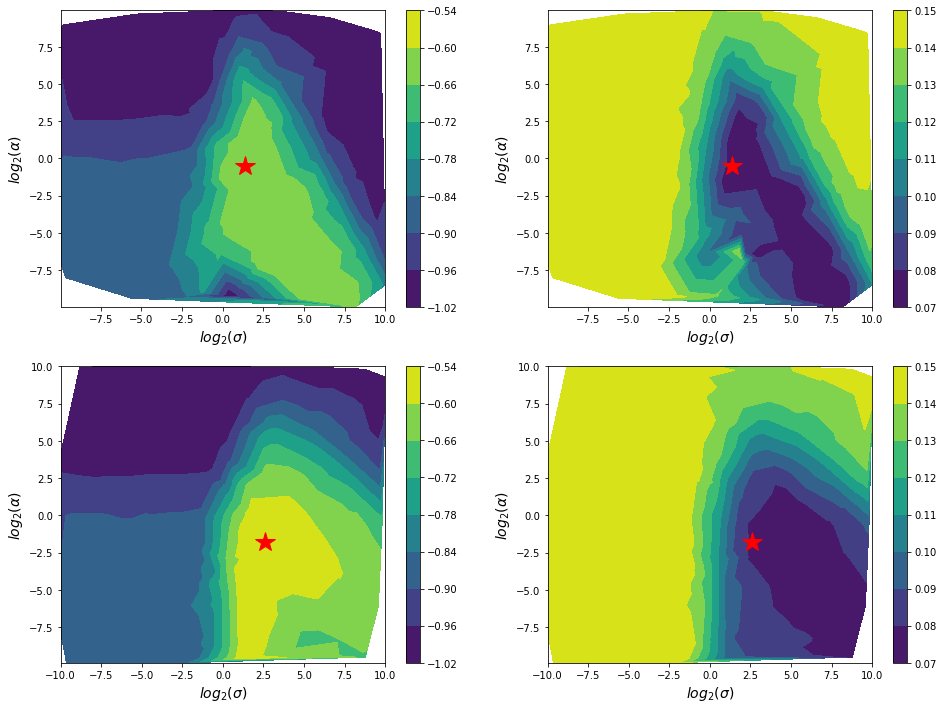

In [23]:
# Plot results
if load_rand:
    generateContourPlots(rgauss, rlap)

In [24]:
# Kernel Ridge - Grid Search After Random Search
if run_searches['grid']: # Computationally expensive, don't want to always run
    if load_rand:
        # Want to stay in yellow range on graph
        
        # Gauss Params
        if rgauss_1d.best_score_ > rgauss.best_score_:
            alpha_center_gauss = rgauss_1d.best_params_['alpha']
            gamma_center_gauss = 0.1
            gammas_gauss = np.linspace(0.03, 0.17, 20)
        else:
            alpha_center_gauss = rgauss.best_params_['alpha']
            gamma_center_gauss = rgauss.best_params_['gamma']
            gammas_gauss = np.linspace(0.4 * gamma_center_gauss, gamma_center_gauss / 0.6, 20)
        
        alphas_gauss = np.linspace(alpha_center_gauss - 0.3, alpha_center_gauss + 0.3, 20)

        
        # Laplacian params
        alpha_center_lap = rlap.best_params_['alpha']
        gamma_center_lap = rlap.best_params_['gamma']
        alphas_lap = np.linspace(alpha_center_lap - 0.2, alpha_center_lap + 0.2, 20)
        gammas_lap = np.linspace(0.5 * gamma_center_lap, 1.5 * gamma_center_lap)
         
        # build grids
        param_grid_gauss = {'alpha':alphas_gauss, 'gamma':gammas_gauss}
        param_grid_lap = {'alpha':alphas_lap, 'gamma':gammas_lap}
        
    else:
        raise ValueError('Random Search has not been ran')
        
    
    ggauss_mse, ggauss = runWineModel(train_dat, test, scaler, KernelRidge(kernel='rbf'),
                                      search='grid', param_grid=param_grid_gauss)
    glap_mse, glap = runWineModel(train_dat, test, scaler, KernelRidge(kernel='laplacian'),
                                  search='grid', param_grid=param_grid_lap)
    
    # Print Results
    print(ggauss_mse, ggauss.best_params_)
    print(glap_mse, glap.best_params_)
    
    # Export models
    dump(ggauss, './GRID_SEARCH_Wine_RBF_Kernel.joblib')
    dump(glap, './GRID_SEARCH_Wine_Laplace_Kernel.joblib')

In [25]:
# Load grid search results
try:
    ggauss = load('./GRID_SEARCH_Wine_RBF_Kernel.joblib')
    glap = load('./GRID_SEARCH_Wine_Laplace_Kernel.joblib')
    load_grid = True
    print(ggauss.best_params_, ggauss.best_score_)
    print(glap.best_params_, glap.best_score_)
except:
    load_grid = False
    raise ValueError('Grid Search has not been ran')

{'alpha': 0.2602583552277165, 'gamma': 0.04473684210526316} -0.5957847566240924
{'alpha': 0.21512891380632426, 'gamma': 0.24872555933146706} -0.5450046463240769


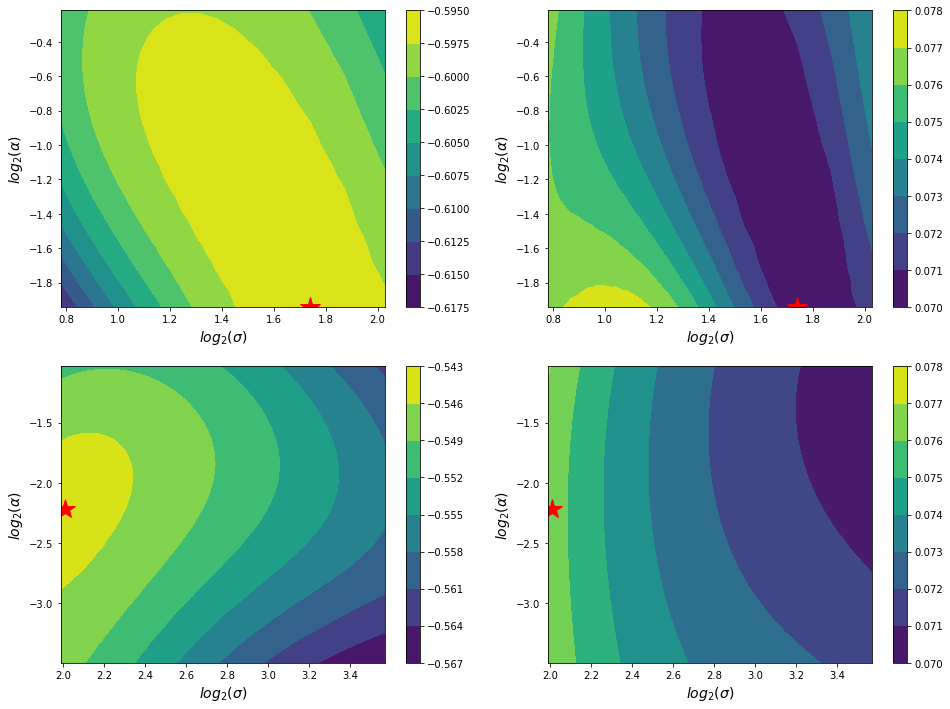

In [26]:
# Plot grid results
if load_grid:
    generateContourPlots(ggauss, glap)

In [27]:
# Get all results in one place
rgauss_mse, _ = runWineModel(train_dat, test, scaler, rgauss.best_estimator_, prefit=True) # random search gauss
rgauss_1d_mse, _ = runWineModel(train_dat, test, scaler, rgauss_1d.best_estimator_, prefit=True) # random search gauss (1d)
rlap_mse, _  = runWineModel(train_dat, test, scaler, rlap.best_estimator_, prefit=True) # random search laplacian
ggauss_mse, _ = runWineModel(train_dat, test, scaler, ggauss.best_estimator_, prefit=True) # refined grid search gauss
glap_mse, _ = runWineModel(train_dat, test, scaler, glap.best_estimator_, prefit=True) # refined grid search lap
print('Base Models:', lin_mse, kgauss_mse, klap_mse)
print('Random Search:', rgauss_mse, rgauss_1d_mse, rlap_mse)
print('Grid Search:', ggauss_mse, glap_mse)

Base Models: (0.6278484956554817, 0.7471696905187134) (0.4474673899912712, 0.6665992233666974) (0.3586005082612411, 0.647975248824071)
Random Search: (0.4490526980172283, 0.6669496529099743) (0.4068379738436188, 0.6639050922026268) (0.10763563992570936, 0.6146736933702996)
Grid Search: (0.4459386298855689, 0.6728272323352847) (0.04827850001352022, 0.6066727825476927)


In [30]:
# Run all the best models on new data
new_wine = np.loadtxt('./wine_new_batch.csv', delimiter=',')
new_wine_scaled = (new_wine - scaler.mean_[:-1]) / scaler.scale_[:-1]
X_new = new_wine_scaled # Rename

# Predict
lin_pred = lin_model.predict(X_new) # Linear Prediction
gauss_pred = rgauss_1d.best_estimator_.predict(X_new) # Gaussian Prediction
glap_pred = glap.best_estimator_.predict(X_new) # Laplacian Prediction

# Unscale
lin_scaled = lin_pred * scaler.scale_[-1] + scaler.mean_[-1]
gauss_scaled = gauss_pred * scaler.scale_[-1] + scaler.mean_[-1]
lap_scaled = glap_pred * scaler.scale_[-1] + scaler.mean_[-1]

# Print Results
print('Linear Results:', lin_scaled)
print('Gauss Results:', gauss_scaled)
print('Laplacian Results:', lap_scaled)

Linear Results: [6.00469789 5.28767761 5.56363072 6.067022   5.94248207]
Gauss Results: [6.11393414 5.49799905 5.53837416 6.19479298 6.19487794]
Laplacian Results: [6.03287334 5.48931914 5.6219042  5.95191513 5.98868236]
